<a href="https://colab.research.google.com/github/justinballas/WorkAutomation/blob/main/BICFR_Portfolio_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [186]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import numpy as np

%matplotlib inline

In [ ]:
pd.set_option('display.max_rows', None)

#Initiate a list of carriers. this abbreviation will be used to import each file based on the carrier name and will double as the alias for each carrier for use throughout the Python script. 
carriers_list = ['COIL','LCL', 'NWD', 'PL', 'PRT', 'MM']

#Using Glob to import files based on carrier name
files = [glob('{}*'.format(carrier)) for carrier in carriers_list]
#Glob returns a list, so when using list comprehentions it will return a list of lists, we must convert to a flat list.
files = [item for elem in files for item in elem]
#Reading in the CSVs, skipfooter removes the summary statistics from the Morningstar output
files = [pd.read_csv(file, skipfooter=13, engine='python') for file in files]
#Converts to a dictionary to easily call DataFrames for each carrier. Dictionary structure is used for looping through different amounts carriers to increase reusability of scripts.
carrier_dfs = dict(zip(carriers_list, files))



#removing "\n" artifact caused by text wrap.
for carrier, df in carrier_dfs.items():
  df.rename(columns=lambda x: x.replace('\n',''), inplace=True)

#remove funds that are closed to new investment
for carrier in carriers_list:
  temp_df = carrier_dfs[carrier]
  temp_df.drop(temp_df[temp_df['Closed to New Inv']=='Yes'].index, inplace=True)

df

In [178]:
#Selecting columns used in BICFR
cols_list = ['Name',
 'Morningstar Category',
 'Advisor',
 'Total Ret 1 Yr (Mo-End) Base Currency',
 'Total Ret Annlzd 3 Yr (Mo-End) Base Currency',
 'Total Ret Annlzd 5 Yr (Mo-End) Base Currency',
 'Total Ret Annlzd 10 Yr (Mo-End) Base Currency',
 'Morningstar Rating Overall',
 'Morningstar Rating 3 Yr',
 'Morningstar Rating 5 Yr',
 'Morningstar Rating 10 Yr',
 'Total Ret % Rank Cat 1 Yr (Mo-End)',
 'Total Ret % Rank Cat 3 Yr (Mo-End)',
 'Total Ret % Rank Cat 5 Yr (Mo-End)',
 'Total Ret % Rank Cat 10 Yr (Mo-End)',
 'Manager Tenure (Average)',
 'Sharpe Ratio 3 Yr (Mo-End) Risk Currency',
 'Std Dev 3 Yr (Mo-End) Risk Currency',
 'Prospectus Net Expense Ratio']

for carrier, df in carrier_dfs.items():
  carrier_dfs[carrier] = df.loc[:,cols_list]

#Remove prefixes in Morningstar Category
replace_list = ['US VL Sub ', 'US Insurance ', 'US Fund ']

for carrier in carriers_list:
  temp_df = carrier_dfs[carrier]
  for phrase in replace_list:
    temp_df['Morningstar Category'] = temp_df['Morningstar Category'].str.replace(phrase, "")

#Concat into single dataframe with carrier and fund name as a multi index
[df.insert(loc=0, column='Carrier', value=carrier) for carrier, df in carrier_dfs.items()]
df = pd.concat(carrier_dfs.values())
df.set_index(['Carrier', 'Name'], inplace=True)

# **BICF Selection**

In [ ]:
asset_classes = list(df['Morningstar Category'].dropna().unique())

def bicf_selector(df, closeness_factor=.2):
  BICF = pd.DataFrame()
  df.loc[:,'Sum Rating'] = df['Morningstar Rating 3 Yr'] + df['Morningstar Rating 5 Yr'] + df['Morningstar Rating 10 Yr'] + df['Morningstar Rating Overall']
  df.loc[:,'Sum Ranking'] = df['Total Ret % Rank Cat 1 Yr (Mo-End)'] + df['Total Ret % Rank Cat 3 Yr (Mo-End)'] + df['Total Ret % Rank Cat 5 Yr (Mo-End)'] + df['Total Ret % Rank Cat 10 Yr (Mo-End)']
  df.loc[:,'Sum Ranking'] = df.loc[:,'Sum Ranking'].apply(lambda x: 400-x)

  aclass_max_rating = df.loc[:,'Sum Rating'].max()
  max_df = df[df['Sum Rating'] == aclass_max_rating]
  BICF = pd.DataFrame()
  if len(max_df) == 1:
    BICF = max_df
  elif len(max_df) > 1:
    aclass_max_ranking = max_df['Sum Ranking'].max()*(1-closeness_factor)
    filt = max_df['Sum Ranking'] > aclass_max_ranking
    max_df = max_df[filt]
    if len(max_df) == 1:
      BICF = max_df
    else:
      min_exp_ratio = max_df['Prospectus Net Expense Ratio'].min()
      max_df = max_df[max_df['Prospectus Net Expense Ratio'] == min_exp_ratio]
      BICF = max_df

  return BICF

BICF_dfs = []
for carrier_df in carrier_dfs.values():
  carrier_df_list = []
  for asset_class in asset_classes:
    temp_df = carrier_df[carrier_df['Morningstar Category'] == asset_class]
    bicf_df = bicf_selector(temp_df)
    carrier_df_list.append(bicf_df)
  carrier_df_list = pd.concat(carrier_df_list)
  BICF_dfs.append(carrier_df_list)
BICF_dfs = pd.concat(BICF_dfs)
BICF_dfs.set_index(['Carrier', 'Name'], inplace=True)


# **Portfolio Builder**

In [258]:

portfolio_category = dict(
    large_cap = ['Large Blend', 'Large Growth', 'Large Value'],
    mid_cap = ['Mid-Cap Blend'],
    small_cap = ['Small Blend'],
    foreign_large_Cap = ['Foreign Large Blend'],
    foreign_small_Cap = ['Foreign Small/Mid Blend', 'World Small/Mid Stock', 'World Allocation'],
    emerging_markets = ['Diversified Emerging Mkts'],
    real_estate = ['Global Real Estate'],
    FI_short_term = ['Short-Term Bond'],
    FI_intermediate = ['Intermediate Core Bond', 'Intermediate Core-Plus Bond'],
    FI_inflation_protected = ['Inflation-Protected Bond'],
    FI_high_yield = ['High Yield Bond'],
    world_bond = ['World Bond'],
    Money_Market = ['Money Market - Taxable', 'Prime Money Market', 'Long Government']
)

In [224]:
portfolio_category

{'FI_high_yield': ['High Yield Bond'],
 'FI_inflation_protected': ['Inflation-Protected Bond'],
 'FI_intermediate': ['Intermediate Core Bond', 'Intermediate Core-Plus Bond'],
 'FI_short_term': ['Short-Term Bond'],
 'Money_Market': ['Money Market - Taxable', 'Prime Money Market'],
 'emerging_markets': ['Diversified Emerging Mkts'],
 'foreign_large_Cap': ['Foreign Large Blend'],
 'foreign_small_Cap': ['Foreign Small/Mid Blend',
  'World Small/Mid Stock',
  'World Allocation'],
 'large_cap': ['Large Blend', 'Large Growth', 'Large Value'],
 'mid_cap': ['Mid-Cap Blend'],
 'real_estate': ['Global Real Estate'],
 'small_cap': ['Small Blend'],
 'world_bond': ['World Bond']}

In [232]:
agg_wts = dict(
    large_cap = .4,
    mid_cap = .18,
    small_cap = .12,
    foreign_large_Cap = .14,
    foreign_small_Cap = .05,
    emerging_markets = .06,
    real_estate = .05,
    FI_short_term = 0,
    FI_intermediate = 0,
    FI_inflation_protected = 0,
    FI_high_yield = 0,
    world_bond = 0,
    Money_Market = 0
)

mod_agg_wts = dict(
    large_cap = .35,
    mid_cap = .15,
    small_cap = .10,
    foreign_large_Cap = .11,
    foreign_small_Cap = .04,
    emerging_markets = .05,
    real_estate = .05,
    FI_short_term = 0,
    FI_intermediate = 6,
    FI_inflation_protected = 0,
    FI_high_yield = 0,
    world_bond = .04,
    Money_Market = .05
)

mod_wts = dict(
    large_cap = .25,
    mid_cap = .12,
    small_cap = .08,
    foreign_large_Cap = .08,
    foreign_small_Cap = .03,
    emerging_markets = .04,
    real_estate = .05,
    FI_short_term = .03,
    FI_intermediate = .09,
    FI_inflation_protected = .03,
    FI_high_yield = .03,
    world_bond = .12,
    Money_Market = .05
)

mod_con_wts = dict(
    large_cap = .2,
    mid_cap = .07,
    small_cap = .03,
    foreign_large_Cap = .05,
    foreign_small_Cap = .02,
    emerging_markets = .03,
    real_estate = .05,
    FI_short_term = .05,
    FI_intermediate = .15,
    FI_inflation_protected = .05,
    FI_high_yield = .05,
    world_bond = .2,
    Money_Market = .05
)

con_wts = dict(
    large_cap = .13,
    mid_cap = .05,
    small_cap = .02,
    foreign_large_Cap = .05,
    foreign_small_Cap = 0,
    emerging_markets = 0,
    real_estate = .05,
    FI_short_term = .06,
    FI_intermediate = .18,
    FI_inflation_protected = .06,
    FI_high_yield = .06,
    world_bond = .24,
    Money_Market = .10
)

In [267]:
portfolio_1 = {cat: temp_df[temp_df['Morningstar Category'].isin(aclass)]['Sum Ranking'].idxmax() for cat, aclass in portfolio_category.items()}

In [271]:
portfolio_1

{'FI_high_yield': 'Innovator-BlackRock High Yield V.I. I',
 'FI_inflation_protected': 'Innovator-PIMCO VIT Real Return Admin',
 'FI_intermediate': 'Innovator-Fidelity® VIP Investment Grade Bd Svc',
 'FI_short_term': 'Innovator-Vanguard VIF Short Term Invmt Grade',
 'Money_Market': 'Innovator-PIMCO VIT Long-Term US Govt Admin',
 'emerging_markets': 'Innovator-Fidelity® VIP Emerging Markets Service',
 'foreign_large_Cap': 'Innovator-MFS® VIT II Research International Svc',
 'foreign_small_Cap': 'Innovator-American Funds IS® Global Small Cap 2',
 'large_cap': 'Innovator-Morgan Stanley VIF Growth I',
 'mid_cap': 'Innovator-Vanguard VIF Mid-Cap Index',
 'real_estate': 'Innovator-MFS® VIT III Global Real Estate Initial',
 'small_cap': 'Innovator-Invesco V.I. Main Street Small Cap I',
 'world_bond': 'Innovator-American Funds IS® Capital World Bond 2'}

In [296]:
portfolio_df = pd.DataFrame(data={'Asset Class': list(portfolio_1.keys()), 'Fund Name': list(portfolio_1.values())})

In [299]:
portfolio_df['1-Yr.'] = portfolio_df['Fund Name'].apply(lambda x: df.loc[('NWD',x)]['Total Ret 1 Yr (Mo-End) Base Currency'])

In [300]:
portfolio_df

,Asset Class,Fund Name,1-Yr.
0,large_cap,Innovator-Morgan Stanley VIF Growth I,59.06
1,mid_cap,Innovator-Vanguard VIF Mid-Cap Index,46.99
2,small_cap,Innovator-Invesco V.I. Main Street Small Cap I,63.25
3,foreign_large_Cap,Innovator-MFS® VIT II Research International Svc,37.07
4,foreign_small_Cap,Innovator-American Funds IS® Global Small Cap 2,50.72
5,emerging_markets,Innovator-Fidelity® VIP Emerging Markets Service,59.30
6,real_estate,Innovator-MFS® VIT III Global Real Estate Initial,36.36
7,FI_short_term,Innovator-Vanguard VIF Short Term Invmt Grade,3.26
8,FI_intermediate,Innovator-Fidelity® VIP Investment Grade Bd Svc,2.67
9,FI_inflation_protected,Innovator-PIMCO VIT Real Return Admin,8.34


In [294]:
df.loc[('NWD', 'Innovator-Vanguard VIF Mid-Cap Index')]

Morningstar Category                                  Mid-Cap Blend
Advisor                                          Vanguard Group Inc
Total Ret 1 Yr (Mo-End) Base Currency                         46.99
Total Ret Annlzd 3 Yr (Mo-End) Base Currency                  16.02
Total Ret Annlzd 5 Yr (Mo-End) Base Currency                  15.17
Total Ret Annlzd 10 Yr (Mo-End) Base Currency                 12.51
Morningstar Rating Overall                                        5
Morningstar Rating 3 Yr                                           5
Morningstar Rating 5 Yr                                           5
Morningstar Rating 10 Yr                                          5
Total Ret % Rank Cat 1 Yr (Mo-End)                               89
Total Ret % Rank Cat 3 Yr (Mo-End)                                2
Total Ret % Rank Cat 5 Yr (Mo-End)                                7
Total Ret % Rank Cat 10 Yr (Mo-End)                               3
Manager Tenure (Average)                        

In [291]:
df.loc['NWD'].loc['Innovator-AB VPS Growth and Income A']

12.46

#**Carrier Aggregation**

**Overall Comparison**

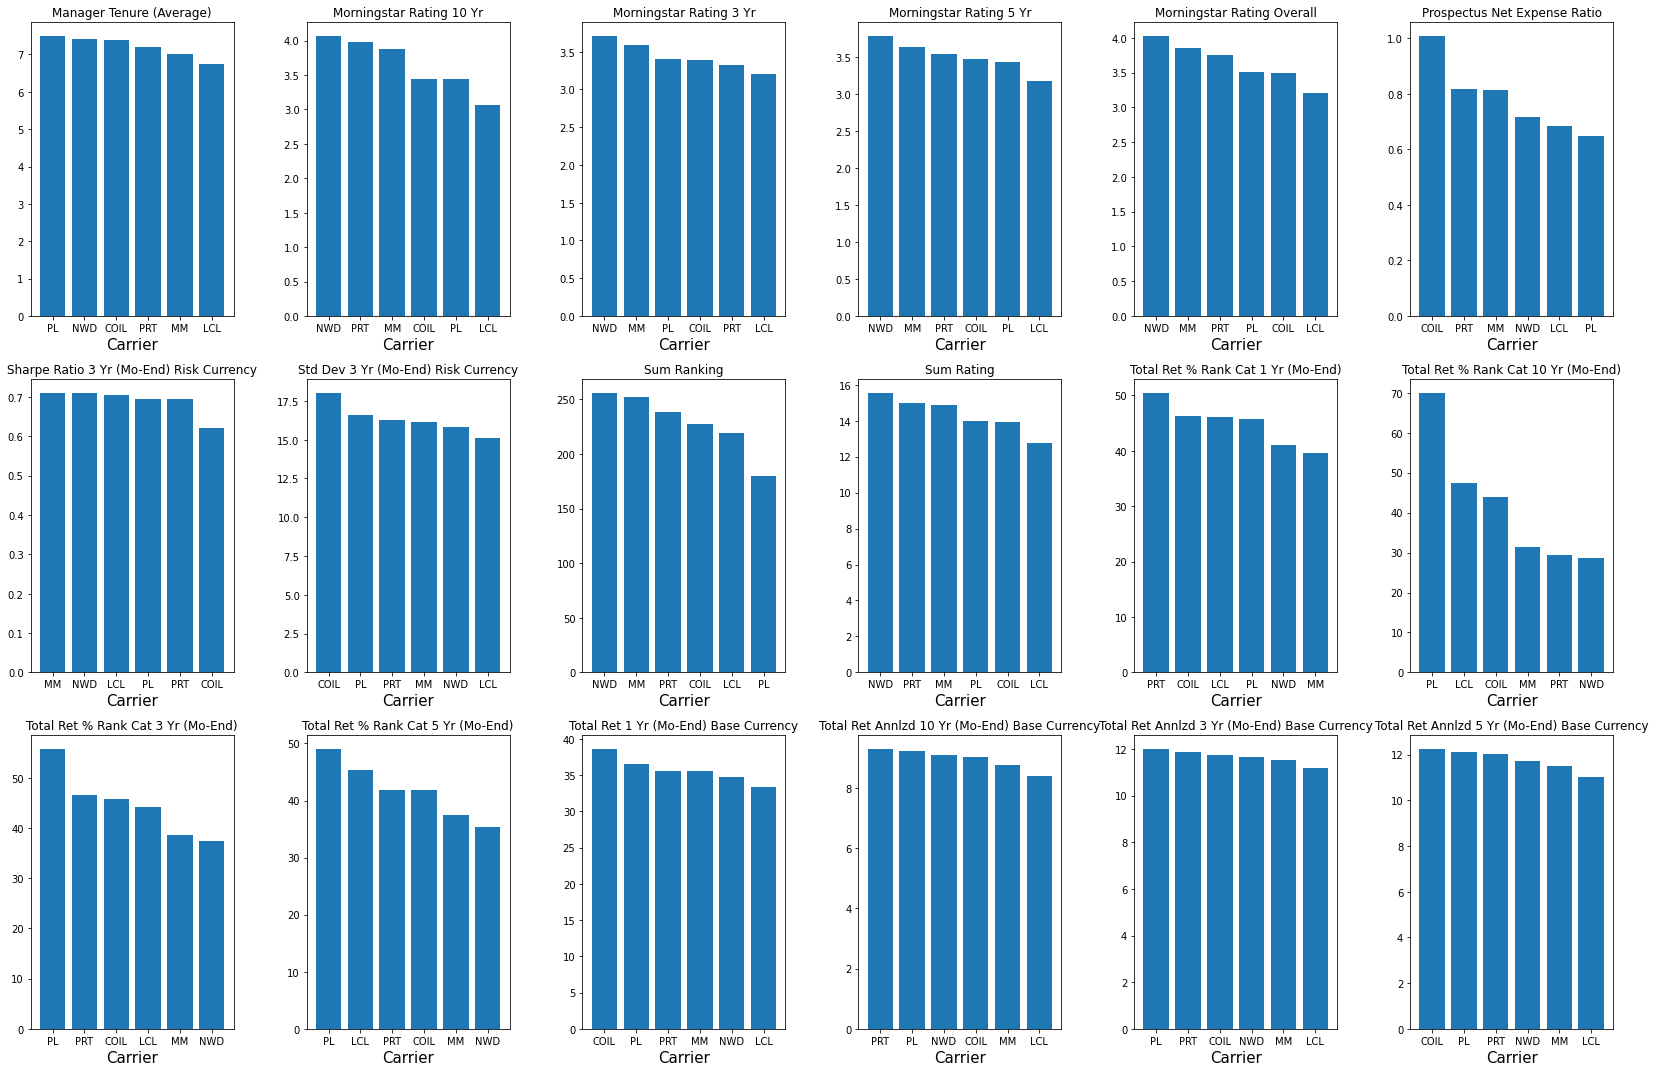

In [189]:
#creating a pivot table to aggregate carrier fund data for rankings.
pivot_table = pd.pivot_table(df, index='Carrier', fill_value=np.nan)

fig = plt.figure(figsize=[23, 15])

for col in enumerate(list(pivot_table.columns)):
  temp_pivot = pivot_table[col[1]].sort_values(ascending=False)
  ax = fig.add_subplot(3, len(pivot_table.columns)/3, col[0]+1)
  plt.title(col[1])
  plt.xlabel('Carrier',fontsize=15)
  x = temp_pivot.index
  y = temp_pivot.values
  ax.bar(x=x, height=y)
  plt.tight_layout()

**Best in Class Fund Comparison**

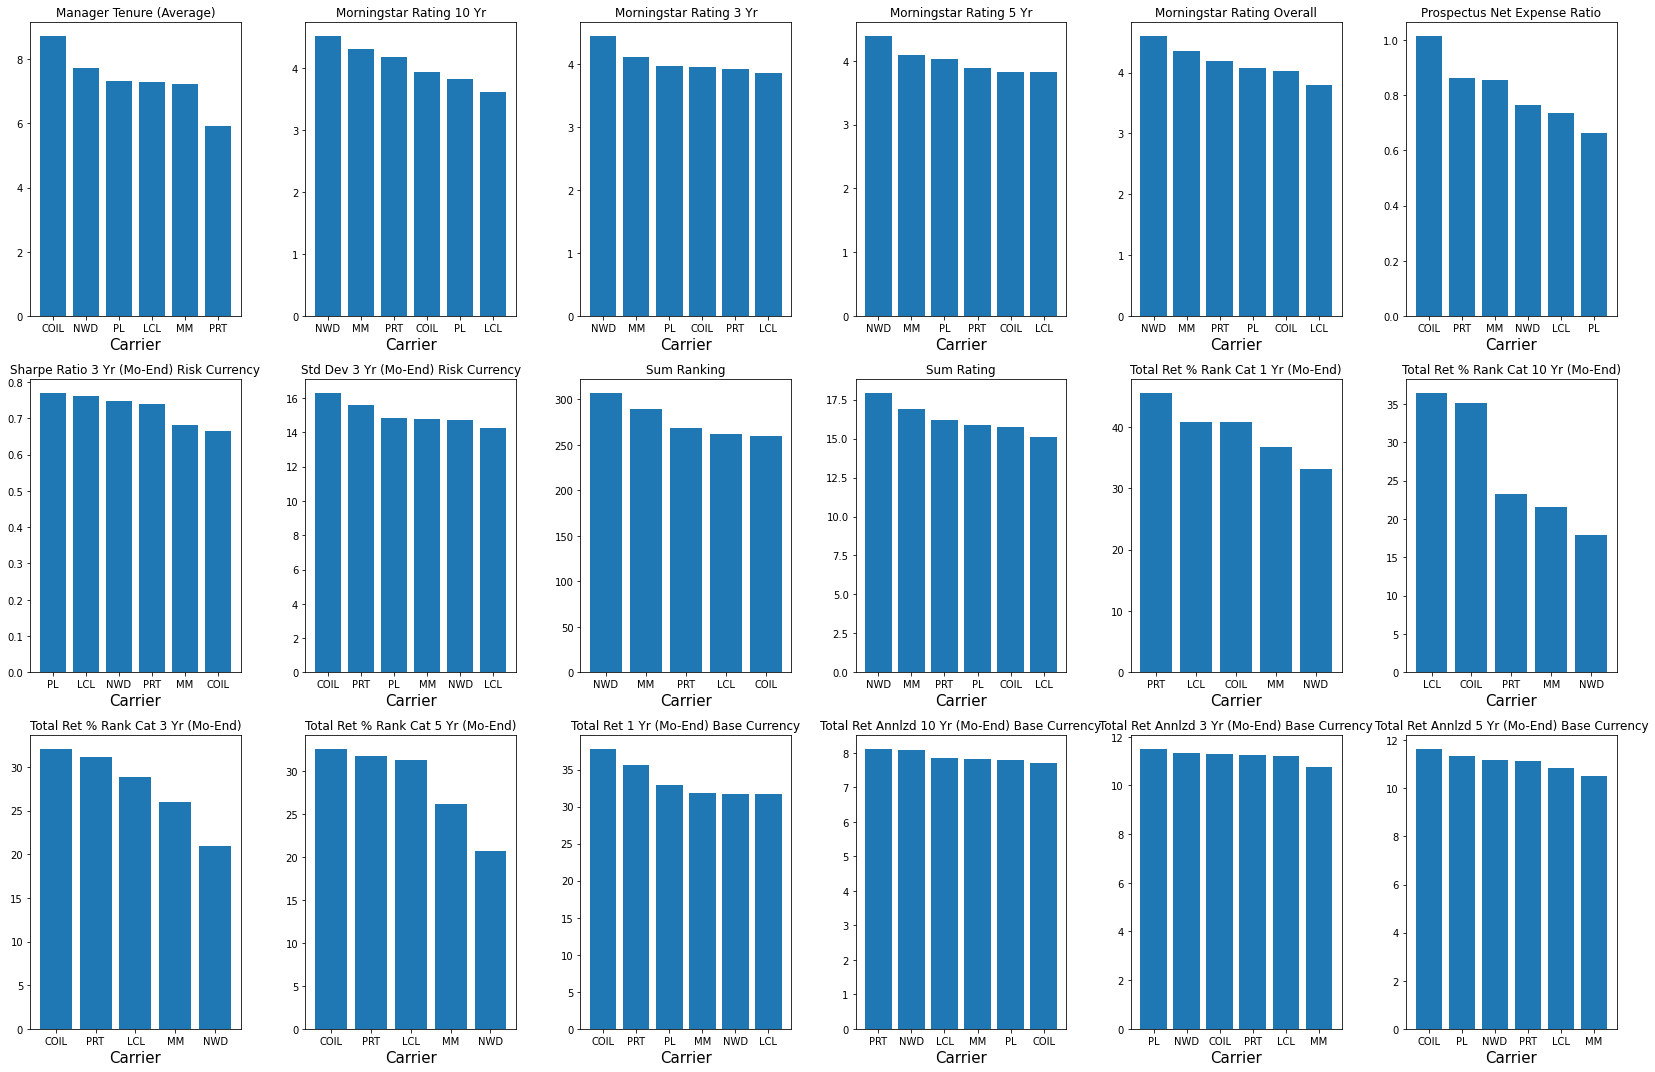

In [191]:
pivot_table = BICF_dfs.pivot_table(index='Carrier')

fig = plt.figure(figsize=[23, 15])

for col in enumerate(list(pivot_table.columns)):
  temp_pivot = pivot_table[col[1]].sort_values(ascending=False)
  ax = fig.add_subplot(3, len(pivot_table.columns)/3, col[0]+1)
  plt.title(col[1])
  plt.xlabel('Carrier',fontsize=15)
  x = temp_pivot.index
  y = temp_pivot.values
  ax.bar(x=x, height=y)
  plt.tight_layout()

**Portfolio Comparison**

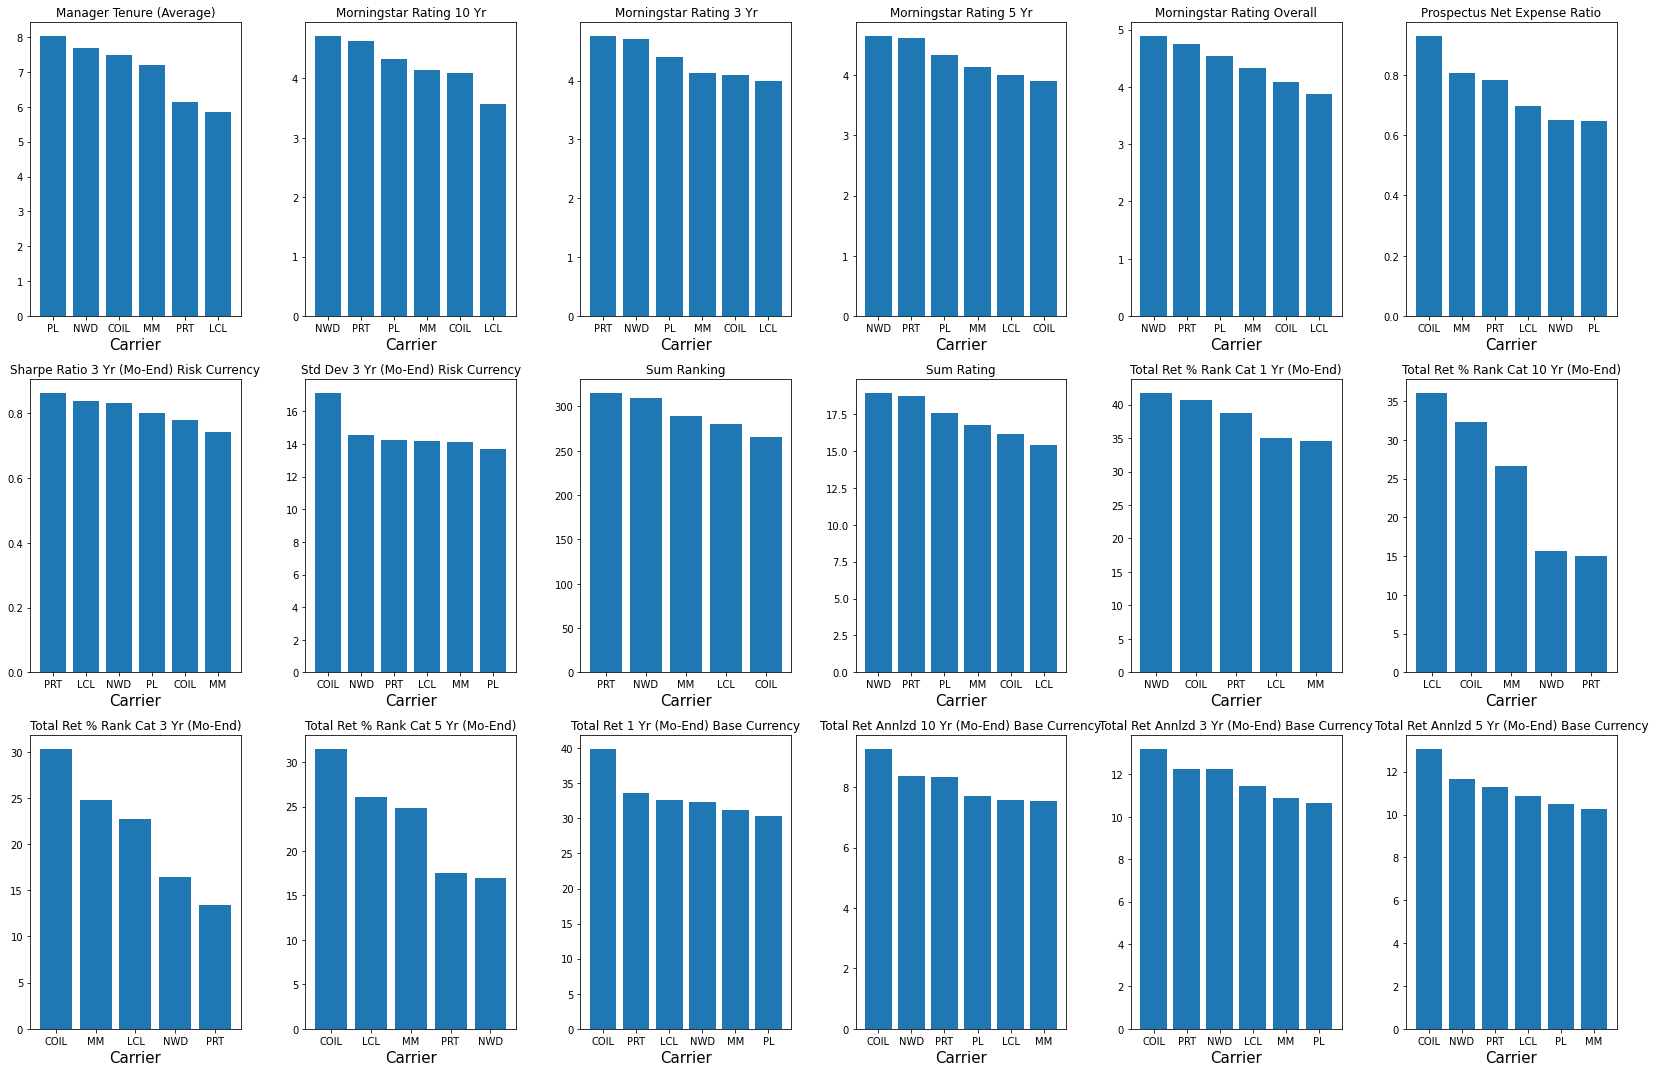

In [205]:
portfolio_list = [item for elem in portfolio_category.values() for item in elem]

pivot_table = BICF_dfs[BICF_dfs['Morningstar Category'].isin(portfolio_list)].pivot_table(index='Carrier')

fig = plt.figure(figsize=[23, 15])

for col in enumerate(list(pivot_table.columns)):
  temp_pivot = pivot_table[col[1]].sort_values(ascending=False)
  ax = fig.add_subplot(3, len(pivot_table.columns)/3, col[0]+1)
  plt.title(col[1])
  plt.xlabel('Carrier',fontsize=15)
  x = temp_pivot.index
  y = temp_pivot.values
  ax.bar(x=x, height=y)
  plt.tight_layout()

**Total Rank Dispersion by carrier**

In [ ]:
#######################

# **Best Carrier By Portfolio Category**

In [204]:
best_by_cat = {}
for cat, aclass in portfolio_category.items():
  best_by_aclass = df[df['Morningstar Category'].isin(aclass)].groupby('Carrier').mean()['Morningstar Rating Overall'].idxmax()
  best_by_cat[cat] = best_by_aclass
best_by_cat

{'FI_high_yield': 'NWD',
 'FI_inflation_protected': 'MM',
 'FI_intermediate': 'PL',
 'FI_short_term': 'MM',
 'Money_Market': nan,
 'emerging_markets': 'PRT',
 'foreign_large_Cap': 'NWD',
 'foreign_small_Cap': 'PRT',
 'large_cap': 'PRT',
 'mid_cap': 'PRT',
 'real_estate': 'MM',
 'small_cap': 'NWD',
 'world_bond': 'PL'}

# **Portfolio Returns**